# Rydberg Annealing – Fig. 1(a) Time‑Series (QuTiP)

This notebook simulates the 7‑atom graph (**G3**) from the paper's Fig. 1(a) using QuTiP. It follows the three‑segment schedule \(\Omega(t),\Delta(t)\), evolves with `mesolve`, and plots:

1. Assignment probabilities \(P[(x_1,x_2)\in\{(0,0),(0,1),(1,0),(1,1)\}]\) vs time.
2. The **top‑4 basis states at the final time**, each tracked vs time.

**Note.** If QuTiP isn't installed, run the install cell below.


## Reference

**Byun, A.; Jung, J.; Kim, K.; Kim, M.; Jeong, S.; Jeong, H.; Ahn, J.**  
*Rydberg-Atom Graphs for Quadratic Unconstrained Binary Optimization Problems.*  
Advanced Quantum Technologies (2024).  
DOI: [10.1002/qute.202300398](https://doi.org/10.1002/qute.202300398)

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from qutip import basis, tensor, qeye, sigmax, sigmaz, mesolve

# ---------- Geometry (Table III, G3) ----------
labels = ["x1_1", "x1_2", "W1", "W2", "x2", "a2_1", "a2_2"]
pos = np.array([
    [-11.4,  6.6],
    [-11.4, -6.6],
    [ -7.6,  0.0],
    [  0.0,  0.0],
    [  7.6,  0.0],
    [ 11.4,  6.6],
    [ 11.4, -6.6],
])
N = len(labels)
cutoff = 7.6  # μm – use experimental max connection distance

edges, dists = [], {}
for i in range(N):
    for j in range(i+1, N):
        d = float(np.linalg.norm(pos[i] - pos[j]))
        dists[(i, j)] = d
        if d <= cutoff + 1e-9:
            edges.append((i, j))
print("Edges (d ≤ 7.6 μm):", [(labels[i], labels[j]) for (i,j) in edges])


Edges (d ≤ 7.6 μm): [('W1', 'W2'), ('W2', 'x2')]


In [3]:
# ---------- Operators ----------
def single_site_ops(N):
    sx_list, n_list = [], []
    n_single = (qeye(2) - sigmaz())/2  # |1><1|
    for i in range(N):
        ops_x = [qeye(2)] * N
        ops_n = [qeye(2)] * N
        ops_x[i] = sigmax()
        ops_n[i] = n_single
        sx_list.append(tensor(ops_x))
        n_list.append(tensor(ops_n))
    return sx_list, n_list

sx_list, n_list = single_site_ops(N)

two_pi = 2*np.pi
U0 = 30.0 * two_pi * 1e6  # rad/s at d=cutoff (sets scale of blockade)

H_int = 0
for (i, j) in edges:
    dij = dists[(i, j)]
    Uij = U0 * (cutoff / dij)**6
    H_int = H_int + Uij * (n_list[i] * n_list[j])

Hx = 0.5 * sum(sx_list)   # (Ω/2) Σ σ_x
Hn = -sum(n_list)         # -Δ Σ n
print("Hilbert dim:", 2**N)


Hilbert dim: 128


In [4]:
# ---------- Anneal schedule ----------
T = 2.5e-6
Omega0 = 0.96 * two_pi * 1e6
Delta_i = -4.0 * two_pi * 1e6
Delta_f =  5.0 * two_pi * 1e6

def Omega_of_t(t):
    if t <= 0.1*T:
        return Omega0 * (t/(0.1*T))
    elif t <= 0.9*T:
        return Omega0
    elif t <= T:
        return Omega0 * (1 - (t-0.9*T)/(0.1*T))
    else:
        return 0.0

def Delta_of_t(t):
    if t <= 0.1*T:
        return Delta_i
    elif t <= 0.9*T:
        s = (t-0.1*T)/(0.8*T)
        return Delta_i + s*(Delta_f - Delta_i)
    elif t <= T:
        return Delta_f
    else:
        return Delta_f

H = [H_int, [Hx, lambda t, args: Omega_of_t(t)], [Hn, lambda t, args: Delta_of_t(t)]]

psi0  = tensor([basis(2, 0)] * N)
nt    = 1000
tlist = np.linspace(0.0, T, nt)
sol   = mesolve(H, psi0, tlist, c_ops=[], e_ops=None)
states = sol.states
print("Evolved states:", len(states))


Evolved states: 1000


In [6]:
# ---------- Probabilities over time ----------
def map_bits_to_vars(bitstring):
    bits = [int(b) for b in bitstring]
    x1 = 1 if (bits[0] == 1 and bits[1] == 1) else 0
    x2 = bits[4]
    return (x1, x2)

all_bits = list(itertools.product([0,1], repeat=N))
def ket_from_bits(bits):
    return tensor([basis(2, b) for b in bits])

basis_kets   = [ket_from_bits(bits) for bits in all_bits]
bitstrings   = [''.join(str(b) for b in bits) for bits in all_bits]
prob_mat     = np.zeros((2**N, nt))
Px           = np.zeros((4, nt))  # (00,01,10,11)

for k, psi in enumerate(states):
    # amplitudes -> probabilities for each basis state
    for idx, ket in enumerate(basis_kets):
        amp = ket.overlap(psi)  # complex amplitude
        prob_mat[idx, k] = float(np.abs(amp)**2)

    # aggregate into (x1,x2)
    p00 = p01 = p10 = p11 = 0.0
    for idx, bstr in enumerate(bitstrings):
        p = prob_mat[idx, k]
        x1, x2 = map_bits_to_vars(bstr)
        if   (x1, x2) == (0,0): p00 += p
        elif (x1, x2) == (0,1): p01 += p
        elif (x1, x2) == (1,0): p10 += p
        else:                   p11 += p
    Px[:, k] = [p00, p01, p10, p11]

# Representatives = top‑4 at final time
final_probs = prob_mat[:, -1]
top_idx = np.argsort(-final_probs)[:4]
repr_bitstrings = [bitstrings[i] for i in top_idx]

# Build their time series
basis_probs = np.zeros((len(repr_bitstrings), nt))
for r, bstr in enumerate(repr_bitstrings):
    idx = bitstrings.index(bstr)
    basis_probs[r, :] = prob_mat[idx, :]

repr_labels = []
for bstr in repr_bitstrings:
    bits = tuple(int(c) for c in bstr)
    x1 = 1 if (bits[0] == 1 and bits[1] == 1) else 0
    x2 = bits[4]
    repr_labels.append(f"{bstr} → (x1,x2)=({x1},{x2})")

repr_labels


['1110111 → (x1,x2)=(1,1)',
 '1101011 → (x1,x2)=(1,0)',
 '1110101 → (x1,x2)=(1,1)',
 '1110110 → (x1,x2)=(1,1)']

In [9]:
# ---------- Save CSV ----------
data = {"t_us": tlist*1e6, "P_x1x2_00": Px[0], "P_x1x2_01": Px[1], "P_x1x2_10": Px[2], "P_x1x2_11": Px[3]}
for i, bstr in enumerate(repr_bitstrings):
    data[f"P_state_{bstr}"] = basis_probs[i]
df = pd.DataFrame(data)
csv_name = "fig1a_timeseries_qutip.csv"
df.to_csv(csv_name, index=False)
print("Saved:", csv_name)


Saved: fig1a_timeseries_qutip.csv


## Clean visualization of **all 128 states** with emphasis on the informative ones

This section draws:
- a **heatmap** of `log10(probability)` for all 128 basis states over time, sorted by an *importance* score, and

**Importance score** defaults to the *peak probability* over time for each state. You can switch to `auc` (area under curve) or `var` (temporal variance).


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

def plot_all_states_with_emphasis(
    prob_mat, bitstrings, tlist,
    top_k=8, mode='peak', save_prefix=None,
    cmap_name='cividis', include_heatmap=True,
    bg_alpha=0.08, bg_lw=0.6, highlight_lw=2.2, annotate_peaks=True
):
    # ---- rank states ----
    if mode == 'peak':
        scores = prob_mat.max(axis=1)
    elif mode == 'auc':
        scores = prob_mat.sum(axis=1)
    elif mode == 'var':
        scores = prob_mat.var(axis=1)
    else:
        raise ValueError("mode must be 'peak', 'auc', or 'var'")

    order = np.argsort(-scores)
    ordered_bits = [bitstrings[i] for i in order]
    cmap = cm.get_cmap(cmap_name)
    k = min(top_k, prob_mat.shape[0])
    colors = cmap(np.linspace(0.12, 0.88, k))

    # ---- optional heatmap ----
    if include_heatmap:
        mat_log = np.log10(prob_mat[order, :] + 1e-16)
        fig_hm, ax_hm = plt.subplots(figsize=(8, 6))
        im = ax_hm.imshow(
            mat_log, aspect='auto', origin='lower',
            extent=[tlist[0]*1e6, tlist[-1]*1e6, 0, prob_mat.shape[0]],
            cmap=cmap
        )
        cbar = fig_hm.colorbar(im, ax=ax_hm)
        cbar.set_label('log10 Probability')
        yticks = np.arange(0, k)
        ytick_labels = [f"{ordered_bits[r]} → ({1 if (ordered_bits[r][0]=='1' and ordered_bits[r][1]=='1') else 0},{ordered_bits[r][4]})" for r in yticks]
        ax_hm.set_yticks(yticks)
        ax_hm.set_yticklabels(ytick_labels, fontsize=7)
        ax_hm.set_title(f"All {prob_mat.shape[0]} states (sorted by {mode}) — heatmap")
        ax_hm.set_xlabel("time [μs]")
        ax_hm.set_ylabel("state rank (top at bottom)")
        fig_hm.tight_layout()
        plt.show()

    # ---- overlay plot with emphasis ----
    fig, ax = plt.subplots(figsize=(8, 5))
    # background spaghetti
    for i in range(prob_mat.shape[0]):
        ax.plot(tlist*1e6, prob_mat[i], color=(0.3, 0.3, 0.3, bg_alpha), linewidth=bg_lw)

    # highlight top-K
    def map_bits_to_vars_from_str(bstr):
        bits = tuple(int(c) for c in bstr)
        x1 = 1 if (bits[0]==1 and bits[1]==1) else 0
        x2 = bits[4]
        return x1, x2

    for j in range(k):
        idx = order[j]
        b = bitstrings[idx]
        x1, x2 = map_bits_to_vars_from_str(b)
        lbl = f"{b} → ({x1},{x2})"
        ax.plot(tlist*1e6, prob_mat[idx], label=lbl, linewidth=highlight_lw, color=colors[j])
        if annotate_peaks:
            kp = int(np.argmax(prob_mat[idx]))
            ax.annotate(b, (tlist[kp]*1e6, prob_mat[idx, kp]), xytext=(5, 5),
                        textcoords='offset points', fontsize=7)

    # attach colorbar to THIS axes (fixes your error)
    if k > 0:
        norm = Normalize(vmin=1, vmax=k)
        sm = cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, pad=0.01).set_label(f"Top-{k} rank by {mode}")

    ax.set_title(f"All {prob_mat.shape[0]} states — top-{k} highlighted ({mode})")
    ax.set_xlabel("time [μs]")
    ax.set_ylabel("Probability")
    ax.legend(loc='upper right', fontsize=8)
    fig.tight_layout()
    plt.show()

    return order, scores

/var/folders/6p/gbsv4n_s33111swtcpfvtn200000gn/T/ipykernel_15853/2582630332.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


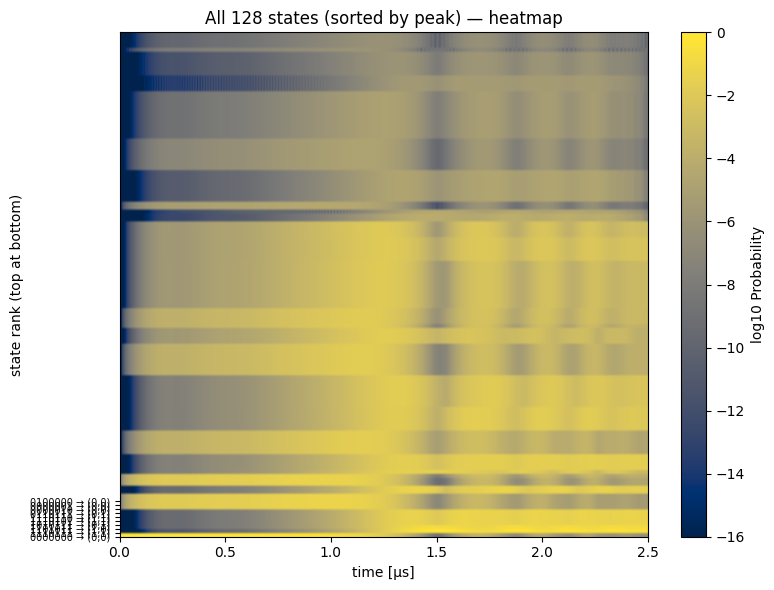

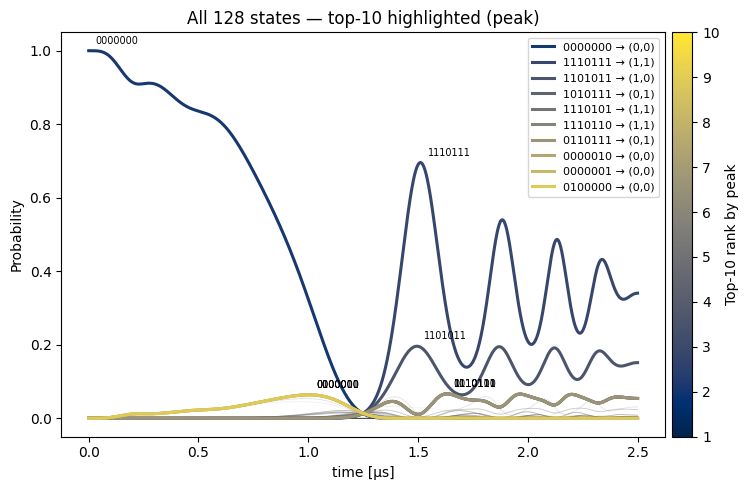

In [20]:
order, scores = plot_all_states_with_emphasis(
    prob_mat, bitstrings, tlist,
    top_k=10, mode='peak',
    cmap_name='cividis', include_heatmap=True
)